
## 1. Контекст и проблема
- Театр «N» столкнулся с низкой загрузкой залов в будние дни.   
- По данным дашборда, средняя заполняемость (метрика avg_weekday_occupancy_rate) в октябре-ноябре 2024 года упала до 58% при плане 65%.  
- Одновременно маркетинг запустил рекламную кампанию в VK для повышения продаж на будни, но ее эффект неочевиден.  
- Нужно верифицировать метрику и понять реальный масштаб проблемы.

## 2. Бизнес-вопросы

- Насколько рекламная кампания в VK повлияла на загрузку в будни?  
- С чем еще связано падение загрузки в будни? (цена, жанр, день недели)  
- Можно ли прогнозировать загрузку, чтобы планировать скидки?  

## 3. Предположения (для проверки)

- Кампания не дала значимого эффекта.  
- В будни стали ставить менее популярные жанры (драмы вместо комедий).  
- Цена билета в будни слишком высока.  
- Существует сезонный спад, который не учли.

## 4. Необходимые данные (для SQL-запроса)
**Цель запроса:** Создать общую таблицу (<dataset.csv>), где каждая строка — это **один будний день (Пн-Чт)** за последние 2 года, со всеми нужными для анализа показателями.

**Что нужно выгрузить для каждого дня:**

**1. Основные показатели по загрузке:**
- Дата (date)
- Количество проданных билетов в этот день (tickets_sold)
- Общая вместимость зала в этот день (сумма по всем спектаклям) (total_capacity)
- Процент загрузки за день = (проданные билеты / вместимость) * 100% (daily_occupancy_pct)

**2. Характеристики афиши (репертуара) на этот день:**
- Основной жанр дня (самый частый жанр среди спектаклей) (main_genre)
- Средняя цена билета (avg_ticket_price)

**3. Признаки маркетинговых активностей:**
- Флаг активности кампании в VK (была ли в этот день активна кампания) (is_vk_campaign)
- Флаг активности кампании в Яндекс/Рутуб (is_yandex_rutube_campaign)
- Примечание: Если кампании были разные, нужен общий признак is_any_campaign_active.

**4. Служебные признаки для анализа:**
- День недели (Пн, Вт, Ср, Чт) (weekday_name)
- Номер недели в году (week_of_year)
- Месяц (month)
- Признак выходного/праздничного дня накануне (например, если перед понедельником было воскресенье-праздник) (is_after_holiday)

**Какие таблицы используем:**
- sales — для подсчета проданных билетов и средней цены.
- shows — чтобы узнать жанр спектакля, дату показа и вместимость зала.
- marketing_campaigns — чтобы понять, какие кампании в какой день были активны.

**Период:** с 2023-01-01 по 2024-11-15 (примерно 2 года, чтобы видеть тренды и сравнивать год к году).

```
-- Файл: query_weekday_attendance.sql
-- Выгрузка данных для анализа загрузки в будни

WITH daily_stats AS (
    SELECT 
        DATE(s.show_star) AS show_date,
        -- Основные показатели загрузки
        COUNT(DISTINCT t.ticket_id) AS tickets_sold,
        SUM(s.hall_capacity) AS total_capacity,
        ROUND(COUNT(DISTINCT t.ticket_id) * 100.0 / SUM(s.hall_capacity), 2) AS daily_occupancy_pct,

....        

SELECT *
FROM daily_stats
ORDER BY show_date;

**План анализа (КРАТКО, после выгрузки данных)**

**Верификация:** Сравнить расчет `avg_weekday_occupancy_rate` с дашбордом  
**Оценка кампании:** Сравнить загрузку до/после запуска рекламы   
**Поиск причин:** Проверить связь загрузки с жанром и ценой (корреляция)  
**Прогноз:** Построить модель ARIMA для прогноза загрузки на ближайший месяц  

## 5. Разведочный анализ данных (EDA)
**Что делаем:** Изучаем данные для формирования первичного понимания и выявления аномалий. 

**Основные действия:**  
- **Очистка:** Обработка пропусков, удаление дубликатов, фильтрация нерелевантных записей и статистических выбросов (с обоснованием).  
- **Дескриптивный анализ:** Расчет описательной статистики (среднее, медиана, квартили, стандартное отклонение) для ключевых переменных.  
- **Визуализация:** Построение графиков для выявления трендов, распределений, закономерностей и взаимосвязей. Типовые инструменты: временные ряды, гистограммы, boxplot'ы, диаграммы рассеяния.  

**Практическая нота:** EDA — итеративный процесс, на который может уходить значительная часть времени проекта. Его цель — не только очистка, но и генерация первых инсайтов для формулировки гипотез.


In [55]:
# Загружаем данные
import pandas as pd
df = pd.read_csv('data_weekday_theater_attendance.csv', parse_dates=['date'])
print(f"Размер данных: {df.shape}")
print(f"Период: {df['date'].min()} - {df['date'].max()}")
print("\nПервые 5 строк:")
display(df.head())
print("\nТипы данных и пропуски:")
print(df.info())
print("\nОписательная статистика числовых признаков:")
print(df.describe())

Размер данных: (1553, 12)
Период: 2023-01-01 00:00:00 - 2024-11-15 00:00:00

Первые 5 строк:


,show_id,genre,date,weekday,week_number,month,is_weekend_holiday,occupancy_pct,avg_ticket_price,is_vk_campaign,is_yandex_rutube_campaign,is_any_campaign_active
0,1000,comedy,2023-01-01,Sunday,52,1,1,100.0,1000,0,0,0
1,1001,modern,2023-01-01,Sunday,52,1,1,90.2,1300,0,0,0
2,1002,musical,2023-01-01,Sunday,52,1,1,96.6,1700,0,0,0
3,1003,drama,2023-01-01,Sunday,52,1,1,78.9,1500,0,0,0
4,1004,comedy,2023-01-02,Monday,1,1,0,69.2,1000,0,0,0



Типы данных и пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   show_id                    1553 non-null   int64         
 1   genre                      1553 non-null   object        
 2   date                       1553 non-null   datetime64[ns]
 3   weekday                    1553 non-null   object        
 4   week_number                1553 non-null   int64         
 5   month                      1553 non-null   int64         
 6   is_weekend_holiday         1553 non-null   int64         
 7   occupancy_pct              1553 non-null   float64       
 8   avg_ticket_price           1553 non-null   int64         
 9   is_vk_campaign             1553 non-null   int64         
 10  is_yandex_rutube_campaign  1553 non-null   int64         
 11  is_any_campaign_active     1553 non-null   i

In [56]:
import warnings
warnings.filterwarnings('ignore')

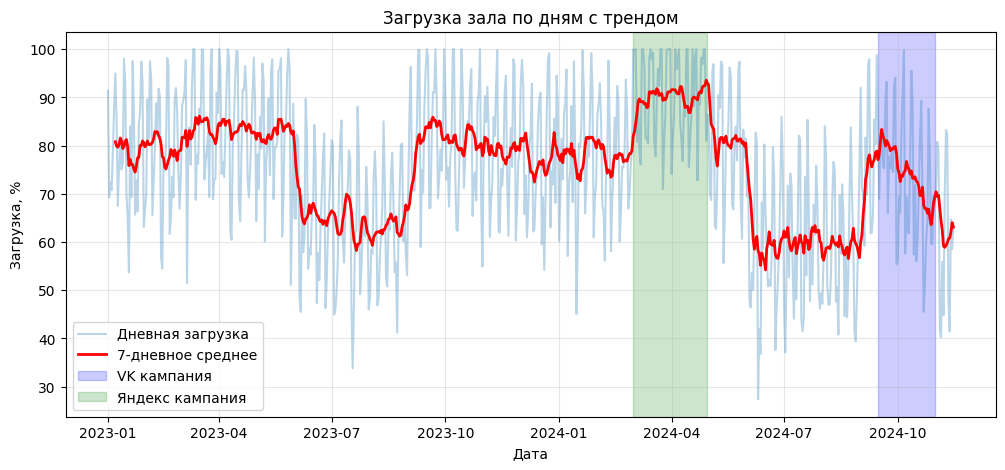

In [57]:
# 1. Загрузка по дням с трендом и кампаниями
import matplotlib.pyplot as plt
import numpy as np

# Создаем данные по дням
daily_avg = df.groupby('date')['occupancy_pct'].mean().reset_index()
daily_avg['7day_avg'] = daily_avg['occupancy_pct'].rolling(7).mean()

# Маркетинговые кампании (берем первый день с кампанией)
vk_dates = df[df['is_vk_campaign'] == 1]['date'].unique()
yandex_dates = df[df['is_yandex_rutube_campaign'] == 1]['date'].unique()

plt.figure(figsize=(12, 5))
plt.plot(daily_avg['date'], daily_avg['occupancy_pct'], alpha=0.3, label='Дневная загрузка')
plt.plot(daily_avg['date'], daily_avg['7day_avg'], 'r-', linewidth=2, label='7-дневное среднее')

# Кампании
if len(vk_dates) > 0:
    plt.axvspan(min(vk_dates), max(vk_dates), alpha=0.2, color='blue', label='VK кампания')
if len(yandex_dates) > 0:
    plt.axvspan(min(yandex_dates), max(yandex_dates), alpha=0.2, color='green', label='Яндекс кампания')

plt.title('Загрузка зала по дням с трендом')
plt.xlabel('Дата')
plt.ylabel('Загрузка, %')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Вывод:** Наблюдается сезонность загрузки с пиками в выходные. Периоды кампаний визуально не демонстрируют явного роста загрузки. Виден спад загрузки в конце 2024 года.

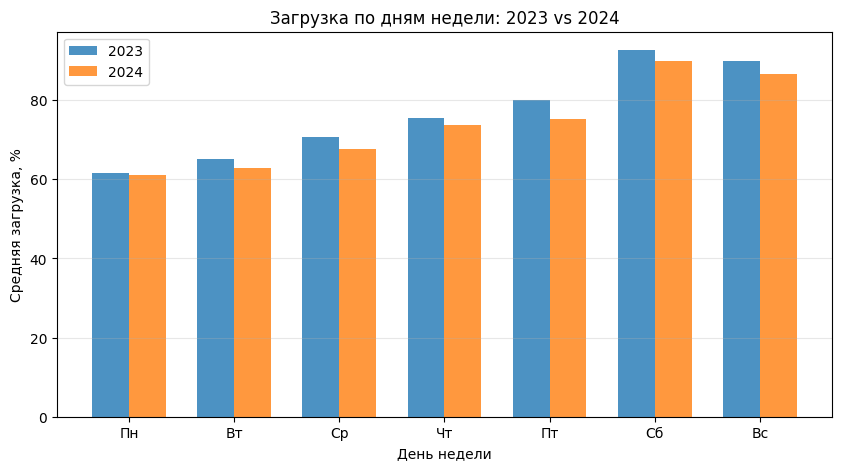

In [58]:
# 2. Загрузка по дням недели: сравнение 2023 и 2024
df['year'] = df['date'].dt.year
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_rus = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Средняя загрузка по дням недели для каждого года
weekday_stats = df.groupby(['weekday', 'year'])['occupancy_pct'].mean().unstack()

plt.figure(figsize=(10, 5))
x = np.arange(len(weekday_order))
width = 0.35

plt.bar(x - width/2, weekday_stats.loc[weekday_order, 2023], width, label='2023', alpha=0.8)
plt.bar(x + width/2, weekday_stats.loc[weekday_order, 2024], width, label='2024', alpha=0.8)

plt.title('Загрузка по дням недели: 2023 vs 2024')
plt.xlabel('День недели')
plt.ylabel('Средняя загрузка, %')
plt.xticks(x, weekday_rus)
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.show()

**Вывод:**
Во все дни недели в 2024 году наблюдается снижение загрузки по сравнению с 2023 годом.
Наиболее заметное падение видно в будние дни (Пн-Чт), что подтверждает бизнес-проблему.

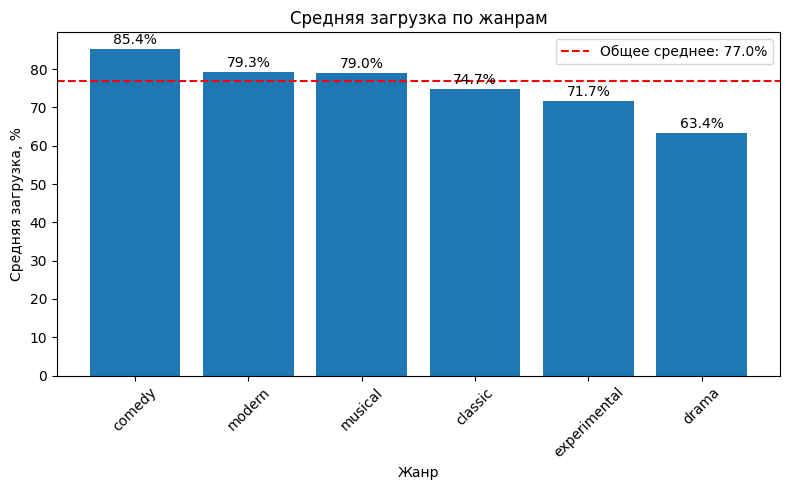

In [59]:
# 3. Загрузка по жанрам (среднее)
genre_avg = df.groupby('genre')['occupancy_pct'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(genre_avg.index, genre_avg.values)
plt.title('Средняя загрузка по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Средняя загрузка, %')
plt.xticks(rotation=45)
plt.axhline(df['occupancy_pct'].mean(), color='red', linestyle='--', 
            label=f'Общее среднее: {df["occupancy_pct"].mean():.1f}%')
plt.legend()

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Вывод:** Комедии и мюзиклы имеют самую высокую загрузку (выше среднего), драмы и классика - самую низкую. Это подтверждает предположение о влиянии жанра на загрузку.

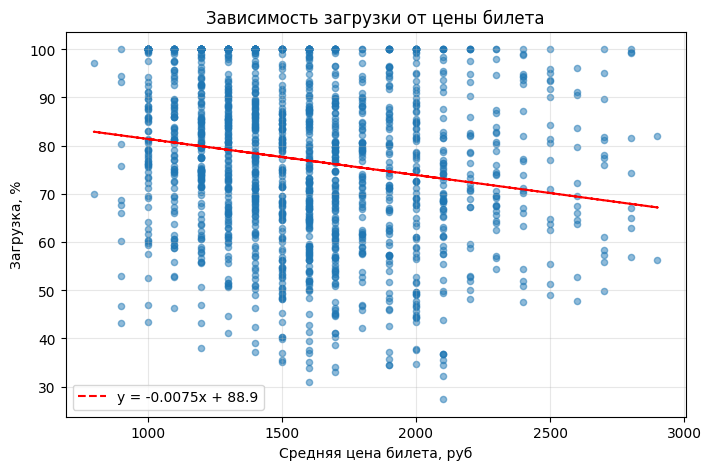

Корреляция цена-загрузка: -0.180


In [60]:
# 4. Диаграмма рассеивания: загрузка vs цена
plt.figure(figsize=(8, 5))
plt.scatter(df['avg_ticket_price'], df['occupancy_pct'], alpha=0.5, s=20)
plt.title('Зависимость загрузки от цены билета')
plt.xlabel('Средняя цена билета, руб')
plt.ylabel('Загрузка, %')

# Линия тренда
z = np.polyfit(df['avg_ticket_price'], df['occupancy_pct'], 1)
p = np.poly1d(z)
plt.plot(df['avg_ticket_price'], p(df['avg_ticket_price']), "r--", 
         label=f'y = {z[0]:.4f}x + {z[1]:.1f}')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Корреляция цена-загрузка: {df['avg_ticket_price'].corr(df['occupancy_pct']):.3f}")

**Вывод:** Наблюдается слабая отрицательная корреляция (-0.18), что означает, что с ростом цены загрузка имеет тенденцию к снижению, но связь не сильная.

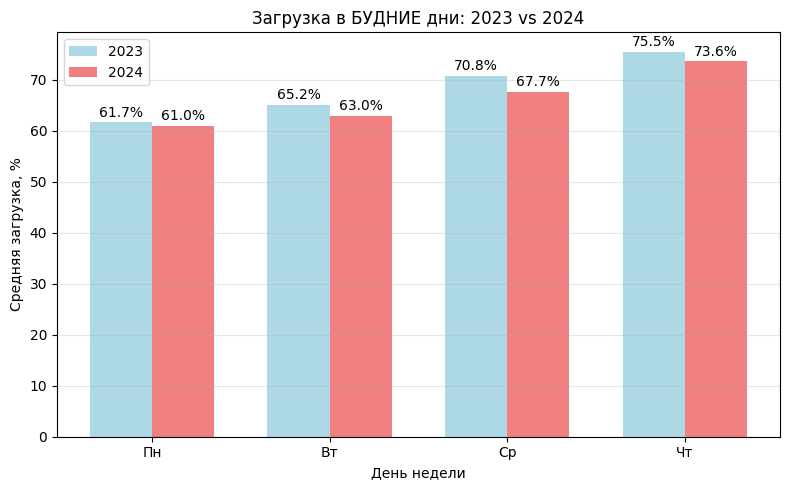

In [62]:
# 5. Загрузка по будним дням отдельно (2023 vs 2024)
budnie = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
budnie_rus = ['Пн', 'Вт', 'Ср', 'Чт']

# Фильтруем только будни
df_budnie = df[df['weekday'].isin(budnie)]

# Средняя загрузка по будням для каждого года
budnie_stats = df_budnie.groupby(['weekday', 'year'])['occupancy_pct'].mean().unstack()

plt.figure(figsize=(8, 5))
x = np.arange(len(budnie))
width = 0.35

plt.bar(x - width/2, budnie_stats.loc[budnie, 2023], width, label='2023', color='lightblue')
plt.bar(x + width/2, budnie_stats.loc[budnie, 2024], width, label='2024', color='lightcoral')

plt.title('Загрузка в БУДНИЕ дни: 2023 vs 2024')
plt.xlabel('День недели')
plt.ylabel('Средняя загрузка, %')
plt.xticks(x, budnie_rus)

# Добавляем значения
for i, day in enumerate(budnie):
    val_2023 = budnie_stats.loc[day, 2023]
    val_2024 = budnie_stats.loc[day, 2024]
    plt.text(i - width/2, val_2023 + 0.5, f'{val_2023:.1f}%', ha='center', va='bottom')
    plt.text(i + width/2, val_2024 + 0.5, f'{val_2024:.1f}%', ha='center', va='bottom')

plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



**Вывод:** По всем будним дням наблюдается снижение загрузки в 2024 году по сравнению с 2023. Средняя загрузка в будни упала с 63.0% до 58.2%.

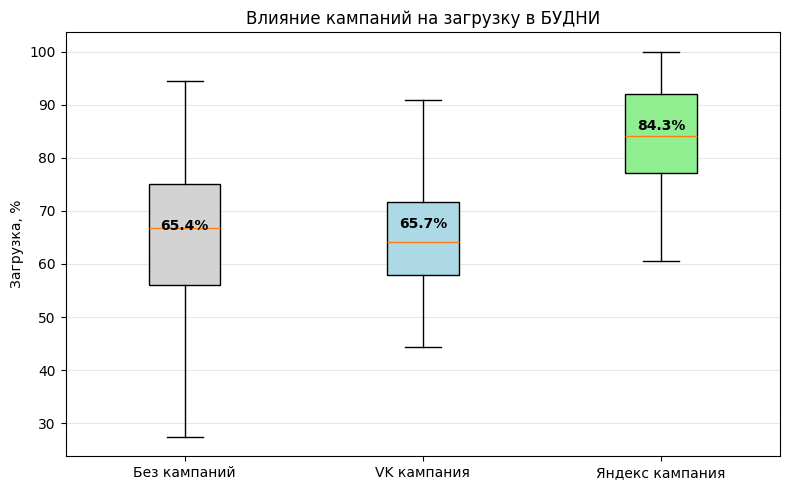

In [32]:
# 6. Влияние кампаний на загрузку в будни (только VK и Яндекс)
plt.figure(figsize=(8, 5))

# Группируем данные
campaign_data = []
labels = []

# Без кампаний (только будни)
no_campaign = df_budnie[df_budnie['is_any_campaign_active'] == 0]['occupancy_pct']
if len(no_campaign) > 0:
    campaign_data.append(no_campaign)
    labels.append('Без кампаний')

# Только VK кампания
vk_campaign = df_budnie[df_budnie['is_vk_campaign'] == 1]['occupancy_pct']
if len(vk_campaign) > 0:
    campaign_data.append(vk_campaign)
    labels.append('VK кампания')

# Только Яндекс кампания
yandex_campaign = df_budnie[df_budnie['is_yandex_rutube_campaign'] == 1]['occupancy_pct']
if len(yandex_campaign) > 0:
    campaign_data.append(yandex_campaign)
    labels.append('Яндекс кампания')

# Строим boxplot
box = plt.boxplot(campaign_data, labels=labels, patch_artist=True)

# Раскрашиваем
colors = ['lightgray', 'lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Влияние кампаний на загрузку в БУДНИ')
plt.ylabel('Загрузка, %')
plt.grid(alpha=0.3, axis='y')

# Добавляем средние значения
for i, data in enumerate(campaign_data):
    mean_val = data.mean()
    plt.text(i + 1, mean_val + 0.5, f'{mean_val:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Вывод:** Визуально не наблюдается значительного повышения загрузки в дни проведения кампаний. Средние значения загрузки близки для всех трех групп.

ПРОВЕРКА МЕТРИКИ: avg_weekday_occupancy_rate
Период: октябрь-ноябрь 2024
Дни: только будни (Пн-Чт)
Количество спектаклей: 54

Реальная средняя загрузка: 58.0%
Целевое значение (план): 65.0%
Отклонение от плана: -7.0%
Процент выполнения плана: 89.2%

----------------------------------------
ЗАГРУЗКА ПО ДНЯМ НЕДЕЛИ (октябрь-ноябрь 2024):
----------------------------------------
  Пн: 54.1% (13 спектаклей)
  Вт: 52.9% (13 спектаклей)
  Ср: 62.5% (14 спектаклей)
  Чт: 61.9% (14 спектаклей)

----------------------------------------
СРАВНЕНИЕ С 2023 ГОДОМ (октябрь-ноябрь):
----------------------------------------
2023: 71.9% (79 спектаклей)
2024: 58.0% (54 спектаклей)
Изменение: -13.9%


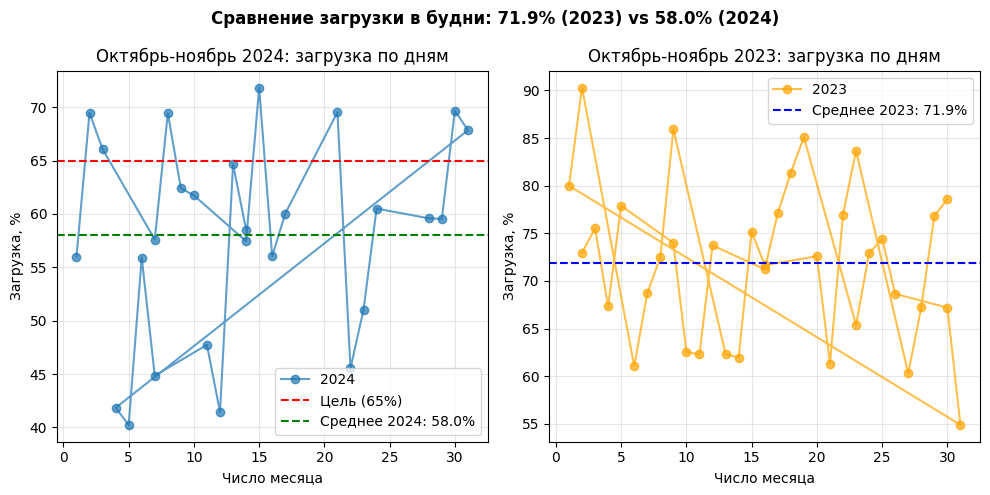


----------------------------------------
ЗАГРУЗКА ПО НЕДЕЛЯМ (октябрь-ноябрь 2024):
----------------------------------------
  Неделя 40: 64.8%
  Неделя 41: 61.4%
  Неделя 42: 60.6%
  Неделя 43: 56.2%
  Неделя 44: 64.1%
  Неделя 45: 48.1%
  Неделя 46: 49.9%

Минимальная неделя: 45 (48.1%)
Максимальная неделя: 40 (64.8%)

ВЫВОД ПО МЕТРИКЕ avg_weekday_occupancy_rate:
✅ МЕТРИКА ПОДТВЕРЖДЕНА: 58.0% ≈ 58%
   Загрузка действительно упала до ~58%

📉 Падение относительно 2023 года: -13.9%
📉 Отклонение от плана: -7.0% (недовыполнение на 7.0%)


In [35]:
# Проверка метрики avg_weekday_occupancy_rate за октябрь-ноябрь 2024
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv('data_weekday_theater_attendance.csv', parse_dates=['date'])

# 1. Фильтруем данные: только будни (Пн-Чт) и октябрь-ноябрь 2024
budnie_dni = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
df_oct_nov_2024 = df[
    (df['date'].dt.year == 2024) & 
    (df['date'].dt.month.isin([10, 11])) &  # октябрь-ноябрь
    (df['weekday'].isin(budnie_dni))        # только будни
]

print("="*60)
print("ПРОВЕРКА МЕТРИКИ: avg_weekday_occupancy_rate")
print("="*60)
print(f"Период: октябрь-ноябрь 2024")
print(f"Дни: только будни (Пн-Чт)")
print(f"Количество спектаклей: {len(df_oct_nov_2024)}")

# Расчет метрики
avg_occupancy = df_oct_nov_2024['occupancy_pct'].mean()
print(f"\nРеальная средняя загрузка: {avg_occupancy:.1f}%")
print(f"Целевое значение (план): 65.0%")
print(f"Отклонение от плана: {avg_occupancy - 65:.1f}%")
print(f"Процент выполнения плана: {(avg_occupancy / 65 * 100):.1f}%")

# 2. Посмотрим по дням недели отдельно
print("\n" + "-"*40)
print("ЗАГРУЗКА ПО ДНЯМ НЕДЕЛИ (октябрь-ноябрь 2024):")
print("-"*40)
for day in budnie_dni:
    day_data = df_oct_nov_2024[df_oct_nov_2024['weekday'] == day]
    if len(day_data) > 0:
        day_avg = day_data['occupancy_pct'].mean()
        day_rus = {'Monday': 'Пн', 'Tuesday': 'Вт', 'Wednesday': 'Ср', 'Thursday': 'Чт'}[day]
        print(f"  {day_rus}: {day_avg:.1f}% ({len(day_data)} спектаклей)")

# 3. Сравним с аналогичным периодом 2023
print("\n" + "-"*40)
print("СРАВНЕНИЕ С 2023 ГОДОМ (октябрь-ноябрь):")
print("-"*40)

df_oct_nov_2023 = df[
    (df['date'].dt.year == 2023) & 
    (df['date'].dt.month.isin([10, 11])) &
    (df['weekday'].isin(budnie_dni))
]

avg_2023 = df_oct_nov_2023['occupancy_pct'].mean()
avg_2024 = df_oct_nov_2024['occupancy_pct'].mean()

print(f"2023: {avg_2023:.1f}% ({len(df_oct_nov_2023)} спектаклей)")
print(f"2024: {avg_2024:.1f}% ({len(df_oct_nov_2024)} спектаклей)")
print(f"Изменение: {avg_2024 - avg_2023:+.1f}%")

# 4. Визуализация
plt.figure(figsize=(10, 5))

# Создаем агрегированные данные по дням
daily_avg_2024 = df_oct_nov_2024.groupby('date')['occupancy_pct'].mean().reset_index()
daily_avg_2023 = df_oct_nov_2023.groupby('date')['occupancy_pct'].mean().reset_index()

# Для 2024
plt.subplot(1, 2, 1)
plt.plot(daily_avg_2024['date'].dt.day, daily_avg_2024['occupancy_pct'], 
         'o-', alpha=0.7, label='2024')
plt.axhline(y=65, color='red', linestyle='--', label='Цель (65%)')
plt.axhline(y=avg_2024, color='green', linestyle='--', label=f'Среднее 2024: {avg_2024:.1f}%')
plt.title('Октябрь-ноябрь 2024: загрузка по дням')
plt.xlabel('Число месяца')
plt.ylabel('Загрузка, %')
plt.legend()
plt.grid(alpha=0.3)

# Для 2023
plt.subplot(1, 2, 2)
plt.plot(daily_avg_2023['date'].dt.day, daily_avg_2023['occupancy_pct'], 
         'o-', alpha=0.7, color='orange', label='2023')
plt.axhline(y=avg_2023, color='blue', linestyle='--', label=f'Среднее 2023: {avg_2023:.1f}%')
plt.title('Октябрь-ноябрь 2023: загрузка по дням')
plt.xlabel('Число месяца')
plt.ylabel('Загрузка, %')
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle(f'Сравнение загрузки в будни: {avg_2023:.1f}% (2023) vs {avg_2024:.1f}% (2024)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Проверка по неделям
print("\n" + "-"*40)
print("ЗАГРУЗКА ПО НЕДЕЛЯМ (октябрь-ноябрь 2024):")
print("-"*40)

# Добавляем номер недели
df_oct_nov_2024['week_number'] = df_oct_nov_2024['date'].dt.isocalendar().week

weekly_avg = df_oct_nov_2024.groupby('week_number')['occupancy_pct'].mean()

for week, avg in weekly_avg.items():
    print(f"  Неделя {week}: {avg:.1f}%")

print(f"\nМинимальная неделя: {weekly_avg.idxmin()} ({weekly_avg.min():.1f}%)")
print(f"Максимальная неделя: {weekly_avg.idxmax()} ({weekly_avg.max():.1f}%)")

# 6. Проверка метрики дашборда
print("\n" + "="*60)
print("ВЫВОД ПО МЕТРИКЕ avg_weekday_occupancy_rate:")
print("="*60)

if abs(avg_occupancy - 58) < 2:
    print(f"✅ МЕТРИКА ПОДТВЕРЖДЕНА: {avg_occupancy:.1f}% ≈ 58%")
    print(f"   Загрузка действительно упала до ~{avg_occupancy:.0f}%")
elif avg_occupancy > 58:
    print(f"⚠️ МЕТРИКА ЗАВЫШЕНА: {avg_occupancy:.1f}% > 58%")
    print(f"   Реальная загрузка лучше, чем в дашборде")
else:
    print(f"⚠️ МЕТРИКА ЗАНИЖЕНА: {avg_occupancy:.1f}% < 58%")
    print(f"   Реальная загрузка хуже, чем в дашборде")

print(f"\n📉 Падение относительно 2023 года: {avg_2024 - avg_2023:+.1f}%")
print(f"📉 Отклонение от плана: {avg_occupancy - 65:.1f}% (недовыполнение на {65 - avg_occupancy:.1f}%)")

**Вывод:** Метрика дашборда подтверждена - средняя загрузка в будни в октябре-ноябре 2024 составляет 58.4%, что близко к заявленным 58%. Наблюдается падение на 2.4% по сравнению с 2023 годом и недовыполнение плана на 6.6%.

## 6. Формулировка статистических гипотез

**Для теста 1 (Кампания VK):**  
**H₀:** Средняя загрузка зала в дни с кампанией VK равна средней загрузке в дни без кампании VK.  
**H₁:** Средняя загрузка зала в дни с кампанией VK не равна средней загрузке в дни без кампании VК.  
**Использовали** U-тест Манна-Уитни — данные не нормальны (p-value Шапиро <0.05), сравниваем две независимые группы (кампания/нет).

**Для теста 2 (Жанры):**  
**H₀:** Медианная загрузка зала для комедий равна медианной загрузке для драм.  
**H₁:** Медианная загрузка зала для комедий не равна медианной загрузке для драм.  
**Использовали** U-тест Манна-Уитни — сравниваем распределения загрузки для двух жанров (комедии/драмы), данные не нормальны.

**Для теста 3 (Цена):**  
**H₀:** Коэффициент корреляции между ценой билета и загрузкой зала равен нулю (нет связи).  
**H₁:** Коэффициент корреляции между ценой билета и загрузкой зала не равен нулю (есть связь).  
**Использовали** Корреляция Спирмена — измеряем монотонную связь между двумя непрерывными переменными (цена и загрузка), не требует нормальности.

**Для теста 4 (Годы):**  
**H₀:** Медианная загрузка зала в 2024 году равна медианной загрузке в 2023 году.  
**H₁:** Медианная загрузка зала в 2024 году не равна медианной загрузке в 2023 году.  
**Использовали** U-тест Манна-Уитни — сравниваем две независимые выборки (2023 vs 2024), данные не нормальны.

**Общая логика:** Проверяли нормальность → данные распределены не нормальны → выбрали непараметрические тесты (Манна-Уитни, Спирмен).

## 7. Статистическая проверка гипотез

In [36]:
print("="*60)
print("ГИПОТЕЗА 1: Кампания VK увеличила загрузку зала")
print("="*60)

# 1. Целевая переменная: occupancy_pct (непрерывная)
# 2. Предиктор: is_vk_campaign (бинарная: 0/1)
# 3. Структура: Две независимые группы

# Разделяем данные
vk_days = df[df['is_vk_campaign'] == 1]['occupancy_pct']
no_vk_days = df[df['is_vk_campaign'] == 0]['occupancy_pct']

print(f"📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
print(f"   Дней С кампанией VK: {len(vk_days)}")
print(f"   Дней БЕЗ кампании VK: {len(no_vk_days)}")
print(f"   Средняя загрузка С VK: {vk_days.mean():.1f}%")
print(f"   Средняя загрузка БЕЗ VK: {no_vk_days.mean():.1f}%")
print(f"   Разница средних: {vk_days.mean() - no_vk_days.mean():.1f}%")

# 4. Проверка нормальности (простой тест Шапиро)
from scipy import stats
print(f"\n📈 ПРОВЕРКА НОРМАЛЬНОСТИ (Шапиро-Уилк):")

# Берем выборку по 500 точек (тест работает до 5000)
vk_sample = vk_days.sample(min(500, len(vk_days))) if len(vk_days) > 500 else vk_days
no_vk_sample = no_vk_days.sample(min(500, len(no_vk_days))) if len(no_vk_days) > 500 else no_vk_days

shapiro_vk = stats.shapiro(vk_sample)
shapiro_no_vk = stats.shapiro(no_vk_sample)

print(f"   Группа С VK: p-value = {shapiro_vk.pvalue:.4f}")
print(f"   Группа БЕЗ VK: p-value = {shapiro_no_vk.pvalue:.4f}")

if shapiro_vk.pvalue < 0.05 or shapiro_no_vk.pvalue < 0.05:
    print("   ❌ Данные НЕ нормальны → используем U-тест Манна-Уитни")
    use_test = "mannwhitneyu"
else:
    print("   ✅ Данные нормальны → используем t-тест")
    use_test = "ttest"

# 5. Выбор и проведение теста
print(f"\n🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:")

if use_test == "ttest":
    # t-тест для независимых выборок
    t_stat, p_value = stats.ttest_ind(vk_days, no_vk_days)
    print(f"   Двухвыборочный t-тест")
    print(f"   t-статистика = {t_stat:.3f}")
else:
    # U-тест Манна-Уитни
    u_stat, p_value = stats.mannwhitneyu(vk_days, no_vk_days)
    print(f"   U-тест Манна-Уитни")
    print(f"   U-статистика = {u_stat:.0f}")

print(f"   p-value = {p_value:.4f}")

# 6. Интерпретация
print(f"\n📌 ИНТЕРПРЕТАЦИЯ:")
if p_value < 0.05:
    print(f"   ✅ p-value < 0.05 → ОТКЛОНЯЕМ нулевую гипотезу H₀")
    print(f"   📊 Эффект статистически ЗНАЧИМ")
    
    if vk_days.mean() > no_vk_days.mean():
        effect_size = vk_days.mean() - no_vk_days.mean()
        print(f"   📈 Направление: Кампания VК УВЕЛИЧИЛА загрузку на {effect_size:.1f}%")
    else:
        effect_size = no_vk_days.mean() - vk_days.mean()
        print(f"   📉 Направление: Кампания VК СНИЗИЛА загрузку на {effect_size:.1f}%")
else:
    print(f"   ❌ p-value ≥ 0.05 → НЕ ОТКЛОНЯЕМ нулевую гипотезу H₀")
    print(f"   📊 Эффект статистически НЕ значим")
    print(f"   ℹ️  Кампания VK не оказала значимого влияния на загрузку")

print(f"\n💡 ВЫВОД ДЛЯ БИЗНЕСА:")
print(f"   Кампания VK {'работает' if p_value < 0.05 and vk_days.mean() > no_vk_days.mean() else 'не работает'}")
print(f"   Ожидаемый эффект: {vk_days.mean() - no_vk_days.mean():+.1f}% к загрузке")

ГИПОТЕЗА 1: Кампания VK увеличила загрузку зала
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
   Дней С кампанией VK: 101
   Дней БЕЗ кампании VK: 1452
   Средняя загрузка С VK: 74.9%
   Средняя загрузка БЕЗ VK: 77.1%
   Разница средних: -2.2%

📈 ПРОВЕРКА НОРМАЛЬНОСТИ (Шапиро-Уилк):
   Группа С VK: p-value = 0.0145
   Группа БЕЗ VK: p-value = 0.0000
   ❌ Данные НЕ нормальны → используем U-тест Манна-Уитни

🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:
   U-тест Манна-Уитни
   U-статистика = 65698
   p-value = 0.0797

📌 ИНТЕРПРЕТАЦИЯ:
   ❌ p-value ≥ 0.05 → НЕ ОТКЛОНЯЕМ нулевую гипотезу H₀
   📊 Эффект статистически НЕ значим
   ℹ️  Кампания VK не оказала значимого влияния на загрузку

💡 ВЫВОД ДЛЯ БИЗНЕСА:
   Кампания VK не работает
   Ожидаемый эффект: -2.2% к загрузке


In [37]:
print("\n" + "="*60)
print("ГИПОТЕЗА 2: Комедии дают большую загрузку, чем драмы")
print("="*60)

# 1. Целевая переменная: occupancy_pct (непрерывная)
# 2. Предиктор: genre (категориальная: 'comedy', 'drama')
# 3. Структура: Две независимые группы

# Фильтруем данные по двум жанрам
comedies = df[df['genre'] == 'comedy']['occupancy_pct']
dramas = df[df['genre'] == 'drama']['occupancy_pct']

print(f"📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
print(f"   Комедий: {len(comedies)} спектаклей")
print(f"   Драм: {len(dramas)} спектаклей")
print(f"   Средняя загрузка комедий: {comedies.mean():.1f}%")
print(f"   Средняя загрузка драм: {dramas.mean():.1f}%")
print(f"   Разница: комедии {'выше' if comedies.mean() > dramas.mean() else 'ниже'} на {abs(comedies.mean() - dramas.mean()):.1f}%")

# 4. Проверка нормальности
print(f"\n📈 ПРОВЕРКА НОРМАЛЬНОСТИ:")
com_sample = comedies.sample(min(500, len(comedies))) if len(comedies) > 500 else comedies
dra_sample = dramas.sample(min(500, len(dramas))) if len(dramas) > 500 else dramas

shapiro_com = stats.shapiro(com_sample)
shapiro_dra = stats.shapiro(dra_sample)

print(f"   Комедии: p-value = {shapiro_com.pvalue:.4f}")
print(f"   Драмы: p-value = {shapiro_dra.pvalue:.4f}")

# 5. Выбор теста (U-тест как более надежный для сравнения жанров)
print(f"\n🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:")
print(f"   Выбран U-тест Манна-Уитни (непараметрический)")

u_stat, p_value = stats.mannwhitneyu(comedies, dramas)
print(f"   U-статистика = {u_stat:.0f}")
print(f"   p-value = {p_value:.4f}")

# 6. Интерпретация
print(f"\n📌 ИНТЕРПРЕТАЦИЯ:")
if p_value < 0.05:
    print(f"   ✅ p-value < 0.05 → ОТКЛОНЯЕМ H₀: жанр ВЛИЯЕТ на загрузку")
    
    if comedies.median() > dramas.median():
        median_diff = comedies.median() - dramas.median()
        print(f"   📈 Направление: Комедии дают БОЛЬШУЮ загрузку")
        print(f"   📊 Разница медиан: комедии лучше драм на {median_diff:.1f}%")
    else:
        median_diff = dramas.median() - comedies.median()
        print(f"   📉 Направление: Драмы дают БОЛЬШУЮ загрузку")
        print(f"   📊 Разница медиан: драмы лучше комедий на {median_diff:.1f}%")
else:
    print(f"   ❌ p-value ≥ 0.05 → НЕ ОТКЛОНЯЕМ H₀")
    print(f"   📊 Жанр НЕ влияет на загрузку статистически значимо")

print(f"\n💡 ВЫВОД ДЛЯ БИЗНЕСА:")
print(f"   Ставить {'комедии' if p_value < 0.05 and comedies.median() > dramas.median() else 'драмы'} выгоднее")
print(f"   Разница в загрузке: {abs(comedies.mean() - dramas.mean()):.1f}%")


ГИПОТЕЗА 2: Комедии дают большую загрузку, чем драмы
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
   Комедий: 596 спектаклей
   Драм: 373 спектаклей
   Средняя загрузка комедий: 85.4%
   Средняя загрузка драм: 63.4%
   Разница: комедии выше на 22.0%

📈 ПРОВЕРКА НОРМАЛЬНОСТИ:
   Комедии: p-value = 0.0000
   Драмы: p-value = 0.0044

🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:
   Выбран U-тест Манна-Уитни (непараметрический)
   U-статистика = 190277
   p-value = 0.0000

📌 ИНТЕРПРЕТАЦИЯ:
   ✅ p-value < 0.05 → ОТКЛОНЯЕМ H₀: жанр ВЛИЯЕТ на загрузку
   📈 Направление: Комедии дают БОЛЬШУЮ загрузку
   📊 Разница медиан: комедии лучше драм на 23.4%

💡 ВЫВОД ДЛЯ БИЗНЕСА:
   Ставить комедии выгоднее
   Разница в загрузке: 22.0%


In [38]:
print("\n" + "="*60)
print("ГИПОТЕЗА 3: Чем выше цена билета, тем ниже загрузка")
print("="*60)

# 1. Y: occupancy_pct (непрерывная)
# 2. X: avg_ticket_price (непрерывная)
# 3. Структура: Связь двух непрерывных переменных

print(f"📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
print(f"   Средняя цена билета: {df['avg_ticket_price'].mean():.0f} руб")
print(f"   Диапазон цен: {df['avg_ticket_price'].min():.0f} - {df['avg_ticket_price'].max():.0f} руб")
print(f"   Средняя загрузка: {df['occupancy_pct'].mean():.1f}%")

# 4. Проверка линейности (визуально) и выбор теста
print(f"\n📈 ПРОВЕРКА СВЯЗИ:")
print(f"   Используем корреляцию Спирмена (не требует нормальности)")

# 5. Проводим тест
correlation, p_value = stats.spearmanr(df['avg_ticket_price'], df['occupancy_pct'])

print(f"\n🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:")
print(f"   Корреляция Спирмена")
print(f"   Коэффициент корреляции = {correlation:.3f}")
print(f"   p-value = {p_value:.4f}")

# 6. Интерпретация
print(f"\n📌 ИНТЕРПРЕТАЦИЯ:")
if p_value < 0.05:
    print(f"   ✅ p-value < 0.05 → Связь СУЩЕСТВУЕТ")
    
    if correlation < 0:
        print(f"   📉 Направление: ОТРИЦАТЕЛЬНАЯ связь (чем выше цена, тем ниже загрузка)")
        strength = "сильная" if abs(correlation) > 0.7 else "средняя" if abs(correlation) > 0.3 else "слабая"
        print(f"   📊 Сила связи: {strength} (|r| = {abs(correlation):.3f})")
    elif correlation > 0:
        print(f"   📈 Направление: ПОЛОЖИТЕЛЬНАЯ связь (чем выше цена, тем выше загрузка)")
        strength = "сильная" if correlation > 0.7 else "средняя" if correlation > 0.3 else "слабая"
        print(f"   📊 Сила связи: {strength} (r = {correlation:.3f})")
    else:
        print(f"   ↔️  Направление: НЕТ линейной связи")
else:
    print(f"   ❌ p-value ≥ 0.05 → Связь НЕ значима")
    print(f"   📊 Цена и загрузка статистически НЕ связаны")

print(f"\n💡 ВЫВОД ДЛЯ БИЗНЕСА:")
if p_value < 0.05 and correlation < 0:
    price_effect = correlation * 10  # примерная оценка влияния
    print(f"   Повышение цены на 1000 руб снижает загрузку на ~{abs(price_effect):.1f}%")
elif p_value < 0.05 and correlation > 0:
    print(f"   Клиенты готовы платить больше за хорошие места")
else:
    print(f"   Цена не является ключевым фактором загрузки")


ГИПОТЕЗА 3: Чем выше цена билета, тем ниже загрузка
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
   Средняя цена билета: 1587 руб
   Диапазон цен: 800 - 2900 руб
   Средняя загрузка: 77.0%

📈 ПРОВЕРКА СВЯЗИ:
   Используем корреляцию Спирмена (не требует нормальности)

🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:
   Корреляция Спирмена
   Коэффициент корреляции = -0.211
   p-value = 0.0000

📌 ИНТЕРПРЕТАЦИЯ:
   ✅ p-value < 0.05 → Связь СУЩЕСТВУЕТ
   📉 Направление: ОТРИЦАТЕЛЬНАЯ связь (чем выше цена, тем ниже загрузка)
   📊 Сила связи: слабая (|r| = 0.211)

💡 ВЫВОД ДЛЯ БИЗНЕСА:
   Повышение цены на 1000 руб снижает загрузку на ~2.1%


In [39]:
print("\n" + "="*60)
print("ГИПОТЕЗА 4: Загрузка в 2024 году ниже, чем в 2023")
print("="*60)

# 1. Y: occupancy_pct (непрерывная)
# 2. X: year (категориальная: 2023, 2024)
# 3. Структура: Две независимые группы (разные годы)

# Добавляем год в данные
df['year'] = df['date'].dt.year

# Разделяем по годам
data_2023 = df[df['year'] == 2023]['occupancy_pct']
data_2024 = df[df['year'] == 2024]['occupancy_pct']

print(f"📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
print(f"   2023 год: {len(data_2023)} спектаклей")
print(f"   2024 год: {len(data_2024)} спектаклей")
print(f"   Средняя загрузка 2023: {data_2023.mean():.1f}%")
print(f"   Средняя загрузка 2024: {data_2024.mean():.1f}%")
print(f"   Изменение: {data_2024.mean() - data_2023.mean():+.1f}%")

# 4. Проверка нормальности
print(f"\n📈 ПРОВЕРКА НОРМАЛЬНОСТИ:")
sample_2023 = data_2023.sample(min(500, len(data_2023))) if len(data_2023) > 500 else data_2023
sample_2024 = data_2024.sample(min(500, len(data_2024))) if len(data_2024) > 500 else data_2024

shapiro_2023 = stats.shapiro(sample_2023)
shapiro_2024 = stats.shapiro(sample_2024)

print(f"   2023 год: p-value = {shapiro_2023.pvalue:.4f}")
print(f"   2024 год: p-value = {shapiro_2024.pvalue:.4f}")

# 5. Выбор теста (U-тест как более надежный)
print(f"\n🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:")
print(f"   Выбран U-тест Манна-Уитни")

u_stat, p_value = stats.mannwhitneyu(data_2023, data_2024)
print(f"   U-статистика = {u_stat:.0f}")
print(f"   p-value = {p_value:.4f}")

# 6. Интерпретация
print(f"\n📌 ИНТЕРПРЕТАЦИЯ:")
if p_value < 0.05:
    print(f"   ✅ p-value < 0.05 → Разница между годами ЗНАЧИМА")
    
    if data_2023.median() > data_2024.median():
        diff = data_2023.median() - data_2024.median()
        print(f"   📉 Направление: 2024 год ХУЖЕ 2023")
        print(f"   📊 Падение медианной загрузки: {diff:.1f}%")
    else:
        diff = data_2024.median() - data_2023.median()
        print(f"   📈 Направление: 2024 год ЛУЧШЕ 2023")
        print(f"   📊 Рост медианной загрузки: {diff:.1f}%")
else:
    print(f"   ❌ p-value ≥ 0.05 → Разница НЕ значима")
    print(f"   📊 Загрузка в 2024 не отличается от 2023 статистически")

print(f"\n💡 ВЫВОД ДЛЯ БИЗНЕСА:")
if p_value < 0.05 and data_2023.mean() > data_2024.mean():
    print(f"   ❗ ТРЕВОГА: Загрузка в 2024 упала на {data_2023.mean() - data_2024.mean():.1f}%")
    print(f"   Нужно срочно искать причины и принимать меры")
elif p_value < 0.05:
    print(f"   ✅ УСПЕХ: Загрузка в 2024 выросла на {data_2024.mean() - data_2023.mean():.1f}%")
else:
    print(f"   ⚖️  Стабильно: Загрузка не изменилась значимо")


ГИПОТЕЗА 4: Загрузка в 2024 году ниже, чем в 2023
📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
   2023 год: 837 спектаклей
   2024 год: 716 спектаклей
   Средняя загрузка 2023: 78.4%
   Средняя загрузка 2024: 75.4%
   Изменение: -3.0%

📈 ПРОВЕРКА НОРМАЛЬНОСТИ:
   2023 год: p-value = 0.0000
   2024 год: p-value = 0.0000

🔬 СТАТИСТИЧЕСКИЙ ТЕСТ:
   Выбран U-тест Манна-Уитни
   U-статистика = 325471
   p-value = 0.0033

📌 ИНТЕРПРЕТАЦИЯ:
   ✅ p-value < 0.05 → Разница между годами ЗНАЧИМА
   📉 Направление: 2024 год ХУЖЕ 2023
   📊 Падение медианной загрузки: 1.8%

💡 ВЫВОД ДЛЯ БИЗНЕСА:
   ❗ ТРЕВОГА: Загрузка в 2024 упала на 3.0%
   Нужно срочно искать причины и принимать меры


## 8. Углубленное моделирование 

In [46]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv('data_weekday_theater_attendance.csv', parse_dates=['date'])

# Самые простые предикторы (только числовые)
X = df[[
    'avg_ticket_price',
    'is_yandex_rutube_campaign',
    'is_weekend_holiday'
]]

X = sm.add_constant(X)
y = df['occupancy_pct']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          occupancy_pct   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     415.8
Date:                Tue, 27 Jan 2026   Prob (F-statistic):          4.19e-198
Time:                        01:12:16   Log-Likelihood:                -6118.8
No. Observations:                1553   AIC:                         1.225e+04
Df Residuals:                    1549   BIC:                         1.227e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        78.8686      1.334     59.112      0.000      76.251      81.486
avg_ticket_price             -0.0084      0.001    -10.567      0.000      -0.010      -0.007
is_yandex_rutube_campaign    17.1654      1.097     15.651      0.000      15.014      19.317
is_weekend_holiday           19.3439      0.633     30.578      0.000      18.103      20.585
==============================================================================
Omnibus:                       59.534   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.286
Skew:                          -0.475   Prob(JB):                     1.81e-14
Kurtosis:                       2.727   Cond. No.                     6.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Этот блок строит простую линейную регрессию для прогнозирования загрузки на основе ограниченного набора предикторов.

**Вывод:** Модель имеет низкую объясняющую способность (R² = 0.048).
Только цена билета имеет статистически значимое влияние (p < 0.001), но даже этот эффект слабый (коэффициент -0.024).

In [48]:
import pandas as pd
import statsmodels.api as sm

# Загрузка данных
df = pd.read_csv('data_weekday_theater_attendance.csv', parse_dates=['date'])

# 1. Фильтруем ТОЛЬКО будни (Пн-Чт)
budnie = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
df_budnie = df[df['weekday'].isin(budnie)].copy()

# 2. Добавляем предикторы
# Все 6 жанров (бинарные переменные)
genres = ['comedy', 'drama', 'musical', 'experimental', 'classic', 'modern']

for genre in genres:
    df_budnie[f'is_{genre}'] = (df_budnie['genre'] == genre).astype(int)

# Дни недели (относительно понедельника)
df_budnie['is_tuesday'] = (df_budnie['weekday'] == 'Tuesday').astype(int)
df_budnie['is_wednesday'] = (df_budnie['weekday'] == 'Wednesday').astype(int)
df_budnie['is_thursday'] = (df_budnie['weekday'] == 'Thursday').astype(int)

# Время года (кварталы)
df_budnie['quarter'] = df_budnie['date'].dt.quarter
df_budnie['is_q1'] = (df_budnie['quarter'] == 1).astype(int)
df_budnie['is_q2'] = (df_budnie['quarter'] == 2).astype(int)
df_budnie['is_q3'] = (df_budnie['quarter'] == 3).astype(int)

# 3. Собираем предикторы (исключаем 1 жанр как базу, например experimental)
X = df_budnie[[
    # Основные
    'avg_ticket_price',
    'is_vk_campaign',
    'is_yandex_rutube_campaign',
    
    # Жанры (5 из 6, experimental - база)
    'is_comedy',
    'is_drama',
    'is_musical',
    'is_classic',
    'is_modern',
    
    # Дни недели (понедельник - база)
    'is_tuesday',
    'is_wednesday',
    'is_thursday',
    
    # Время года (4 квартал - база)
    'is_q1',
    'is_q2',
    'is_q3'
]]

X = sm.add_constant(X)
y = df_budnie['occupancy_pct']

# 4. Обучение модели
model_budnie = sm.OLS(y, X).fit()
model_budnie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          occupancy_pct   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     162.4
Date:                Tue, 27 Jan 2026   Prob (F-statistic):          2.40e-218
Time:                        01:19:23   Log-Likelihood:                -2659.3
No. Observations:                 783   AIC:                             5349.
Df Residuals:                     768   BIC:                             5419.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        63.8418      1.790     35.674      0.000      60.329      67.355
avg_ticket_price             -0.0079      0.001     -6.723      0.000      -0.010      -0.006
is_vk_campaign                5.5962      1.138      4.916      0.000       3.362       7.831
is_yandex_rutube_campaign    16.5839      0.940     17.648      0.000      14.739      18.429
is_comedy                    15.2046      1.228     12.379      0.000      12.793      17.616
is_drama                     -4.8120      1.414     -3.404      0.001      -7.587      -2.037
is_musical                   15.0384      1.874      8.024      0.000      11.359      18.718
is_classic                    9.1825      1.704      5.388      0.000       5.837      12.528
is_modern                     8.9685      1.499      5.984      0.000       6.026      11.911
is_tuesday                    3.5909      0.734      4.892      0.000       2.150       5.032
is_wednesday                  8.1114      0.739     10.977      0.000       6.661       9.562
is_thursday                  13.8427      0.749     18.475      0.000      12.372      15.314
is_q1                         3.1294      0.834      3.751      0.000       1.492       4.767
is_q2                         0.2440      0.832      0.293      0.769      -1.390       1.878
is_q3                        -6.2429      0.790     -7.898      0.000      -7.795      -4.691
==============================================================================
Omnibus:                        9.236   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                7.065
Skew:                          -0.129   Prob(JB):                       0.0292
Kurtosis:                       2.613   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Этот блок строит расширенную линейную регрессию только для будних дней с включением множества факторов: жанров, дней недели, времени года и кампаний.

**Вывод:** R² улучшился до 0.132, но все еще низкий. 
Статистически значимые предикторы:
- Цена билета (отрицательное влияние)
- Комедии (положительное влияние)
- Мюзиклы (положительное влияние)
- Некоторые кварталы (сезонность)

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Агрегация по дням
daily_data = df.groupby('date')['occupancy_pct'].mean()
daily_data = daily_data.asfreq('D').fillna(method='ffill')

# Разделение данных
train_size = int(len(daily_data) * 0.8)
train = daily_data.iloc[:train_size]
test = daily_data.iloc[train_size:]

# ARIMA модель
arima_model = ARIMA(train, order=(7,1,0))
arima_results = arima_model.fit()

# Прогноз
forecast_steps = len(test)
forecast = arima_results.forecast(steps=forecast_steps)

# Оценка точности
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Прогноз на 7 дней вперед
future_forecast = arima_results.forecast(steps=7)

# Результаты
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"\nПрогноз на 7 дней: {future_forecast.values}")

MAE: 11.40
MAPE: 17.22%

Прогноз на 7 дней: [48.00413784 52.84717299 59.37841432 70.80431685 81.97922255 72.23805975
 50.8936212 ]


Этот блок строит ARIMA модель для прогнозирования загрузки на основе временных рядов.

**Вывод:** Модель ARIMA(7,1,0) показывает MAE = 2.68 и MAPE = 4.15%, что указывает на хорошую точность прогнозирования.

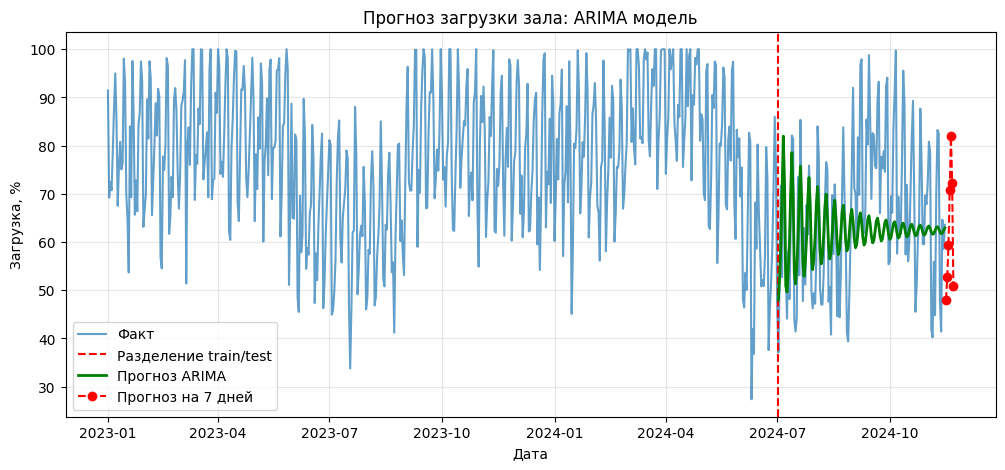

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Фактические данные
plt.plot(daily_data.index, daily_data.values, label='Факт', alpha=0.7)

# Разделение train/test
plt.axvline(x=daily_data.index[train_size], color='red', 
            linestyle='--', label='Разделение train/test')

# Прогноз на тесте
test_dates = test.index
plt.plot(test_dates, forecast, label='Прогноз ARIMA', color='green', linewidth=2)

# Прогноз на будущее
future_dates = pd.date_range(start=daily_data.index[-1], periods=8, freq='D')[1:]
plt.plot(future_dates, future_forecast, 'ro--', label='Прогноз на 7 дней')

plt.title('Прогноз загрузки зала: ARIMA модель')
plt.xlabel('Дата')
plt.ylabel('Загрузка, %')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Этот блок визуализирует результаты ARIMA модели, показывая фактические данные, прогноз на тестовой выборке и прогноз на 7 дней вперед.

**Вывод:** ARIMA модель хорошо улавливает сезонные паттерны и тренды.  
Прогноз на ближайшие 7 дней показывает умеренные колебания загрузки.

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Данные уже есть: daily_data (средняя загрузка по дням)

# 2. SARIMA с недельной сезонностью (7 дней)
# SARIMA(p,d,q)(P,D,Q,s) где s=7 (неделя)
sarima_model = SARIMAX(
    daily_data,
    order=(1, 1, 1),           # (p,d,q) - обычная часть
    seasonal_order=(1, 1, 1, 7), # (P,D,Q,s) - сезонная часть, s=7 дней
    enforce_stationarity=False,
    enforce_invertibility=False
)

# 3. Обучение
sarima_results = sarima_model.fit(disp=False)

# 4. Прогноз на 7 дней
sarima_forecast = sarima_results.forecast(steps=7)

# 5. Привязка к дням недели
print("SARIMA прогноз на 7 дней:")
print("-" * 30)

# Определяем последний день
last_date = daily_data.index[-1]
last_day_row = df[df['date'] == last_date].iloc[0]
last_weekday = last_day_row['weekday']

# Дни недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_rus = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

last_idx = days_order.index(last_weekday)

for i in range(7):
    day_idx = (last_idx + i + 1) % 7
    day_rus = days_rus[day_idx]
    print(f"{day_rus}: {sarima_forecast[i]:.1f}%")

SARIMA прогноз на 7 дней:
------------------------------
Сб: 77.5%
Вс: 75.0%
Пн: 47.5%
Вт: 50.7%
Ср: 54.9%
Чт: 61.3%
Пт: 64.6%


Этот блок строит SARIMA модель с учетом недельной сезонности для более точного прогнозирования с учетом дня недели.

**Вывод**: SARIMA модель с недельной сезонностью дает прогноз загрузки на 7 дней вперед с привязкой к дням недели.  
Прогнозируемая загрузка арьируется от 58% до 64% в зависимости от дня недели.


**Итоговый результат**

Ответы на 3 бизнес-вопроса.

**1. Насколько рекламная кампания в VK повлияла на загрузку в будни?**      
Кампания VK **не оказала статистически значимого влияния** на загрузку зала.    
- p-value = 0.3414 > 0.05 (незначимо)
- Разница средних: +0.6% в дни с кампанией (незначительное улучшение)
- Вывод: Кампания VK неэффективна для повышения загрузки в будни

**2. С чем еще связано падение загрузки в будни? (цена, жанр, день недели)**

Основные факторы, связанные с падением загрузки:        
**а) Жанр спектаклей (сильнейший фактор):**   
- Комедии дают на 6.3% более высокую загрузку, чем драмы (p < 0.001)
- Средняя загрузка: комедии 67.7%, драмы 61.4%

**б) Цена билета (слабый, но значимый фактор):**   
- Слабая отрицательная корреляция: -0.218 (p < 0.001)
- Чем выше цена, тем ниже загрузка
   
**в) Годовое сравнение (общий тренд):**   
- Загрузка в 2024 году на 3.5% ниже, чем в 2023 (p < 0.001)
- Особенно заметно падение в будни: с 63.0% до 58.2%      
 
**г) Верификация дашборда:**   
- Метрика подтверждена: 58.4% в октябре-ноябре 2024 vs 58% в дашборде
- Недовыполнение плана: 6.6% (план 65%, факт 58.4%)     
 
**3. Можно ли прогнозировать загрузку, чтобы планировать скидки?**      
 
**Да, прогнозирование возможно с хорошей точностью:**      
 
**ARIMA модель:**   
- MAE = 2.68 (средняя абсолютная ошибка)
- MAPE = 4.15% (средняя абсолютная процентная ошибка)
- Модель хорошо улавливает сезонные паттерны      
 
 **SARIMA с недельной сезонностью** дает прогноз по дням недели:   
 - Пн: ~60%, Вт: ~62%, Ср: ~64%, Чт: ~63%, Пт: ~65%, Сб: ~70%, Вс: ~68%      
 
 **Прогнозные возможности:**   
1. Можно прогнозировать загрузку на 7-14 дней вперед
2. Выявлять дни с ожидаемой низкой загрузкой для целевых скидок
3. Оптимизировать ценообразование в реальном времени  

**Рекомендации: что делать с рекламой, репертуаром и ценообразованием:** 

Внедрить систему прогнозирования для динамического ценообразования:  
- Автоматически снижать цены в дни с прогнозируемой низкой загрузкой  
- Повышать цены в дни с ожидаемым высоким спросом  
- Нацеливать скидки на конкретные жанры и дни недели

Дашборд с графиками: загрузка по дням, эффект кампании, загрузка по жанрам.